In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Define the TRUE project root (go up one level from the notebook's location)
PROJECT_ROOT = Path.cwd().parent 
SRC_DIR = str(PROJECT_ROOT / "src")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

from healthcare_signals.io import (
    load_facts_daily,
    infer_month_end_snapshots,
    save_provider_panel_snapshot,
    save_provider_panel_full,
)
from healthcare_signals.features_provider import (
    build_provider_panel_for_date,
    build_provider_panel_over_range,
)

print("Project root:", PROJECT_ROOT)

Project root: C:\Users\binia\OneDrive\Bini\Education - Professional Development\Springboard\git\healthcare-stream\healthcare-signals-phase3


In [4]:
facts_daily = load_facts_daily()
print("facts_daily:", facts_daily.shape)
facts_daily.head()

facts_daily: (500, 6)


,date,provider_id,state,claims_cnt,avg_allowed_amt,zscore_allowed_amt
0,2007-10-15,3762822013,ID,1,60.20,NaN
1,2007-10-17,0557475616,ID,1,57.56,NaN
2,2007-11-14,2457354102,NV,1,95.95,NaN
3,2007-11-20,5111491524,AZ,1,26.26,-1.277245
4,2007-12-27,0440012231,UT,1,46.82,NaN


In [6]:
# Month-end snapshot dates across the observation window
snapshot_dates = infer_month_end_snapshots(facts_daily)
print("Number of snapshot dates:", len(snapshot_dates))
print("First 5:", snapshot_dates[:5])
print("Last 5:", snapshot_dates[-5:])

# Optional: restrict to a smaller window (e.g., last 12 months)
#if len(snapshot_dates) > 12:
#    snapshot_dates = snapshot_dates[-12:]

#snapshot_dates


Number of snapshot dates: 40
First 5: DatetimeIndex(['2007-10-31', '2007-11-30', '2007-12-31', '2008-01-31',
               '2008-02-29'],
              dtype='datetime64[ns]', freq='ME')
Last 5: DatetimeIndex(['2010-09-30', '2010-10-31', '2010-11-30', '2010-12-31',
               '2011-01-31'],
              dtype='datetime64[ns]', freq='ME')


In [7]:
from time import perf_counter

start = perf_counter()
panel_all = build_provider_panel_over_range(
    snapshot_dates=snapshot_dates,
    facts_daily=facts_daily,
)
elapsed = perf_counter() - start

print(f"Panel built in {elapsed:.1f} seconds")
print(panel_all.shape)
panel_all.head()

Panel built in 5.7 seconds
(10461, 38)


,provider_id,first_activity_dt,last_activity_dt,total_claims_lifetime,n_active_days_lifetime,mean_zscore_lifetime,days_since_last,n_active_days_30d,total_claims_30d,mean_daily_claims_30d,...,n_active_days_365d,total_claims_365d,mean_daily_claims_365d,mean_allowed_amt_365d,mean_zscore_allowed_365d,claims_std_365d,zscore_std_365d,claims_90d_vs_prev90d,zscore_90d_vs_prev90d,as_of_date
0,0557475616,2007-10-17,2007-10-17,1,1,0.0,14,1.0,1.0,1.0,...,1.0,1.0,1.0,57.56,0.0,0.0,0.0,1.0,0.0,2007-10-31
1,3762822013,2007-10-15,2007-10-15,1,1,0.0,16,1.0,1.0,1.0,...,1.0,1.0,1.0,60.20,0.0,0.0,0.0,1.0,0.0,2007-10-31
2,0557475616,2007-10-17,2007-10-17,1,1,0.0,44,0.0,0.0,0.0,...,1.0,1.0,1.0,57.56,0.0,0.0,0.0,1.0,0.0,2007-11-30
3,2457354102,2007-11-14,2007-11-14,1,1,0.0,16,1.0,1.0,1.0,...,1.0,1.0,1.0,95.95,0.0,0.0,0.0,1.0,0.0,2007-11-30
4,3762822013,2007-10-15,2007-10-15,1,1,0.0,46,0.0,0.0,0.0,...,1.0,1.0,1.0,60.20,0.0,0.0,0.0,1.0,0.0,2007-11-30


In [8]:
# Save concatenated panel
out_full = save_provider_panel_full(panel_all, name="provider_panel_all_dates.parquet")
print("Saved full panel to:", out_full)

# Optionally also save each snapshot separately
for d in snapshot_dates:
    snap_df = panel_all[panel_all["as_of_date"] == pd.to_datetime(d).normalize()].copy()
    if not snap_df.empty:
        save_provider_panel_snapshot(snap_df, d)

print("Per-snapshot parquet files written (if any snapshots existed).")


Saved full panel to: C:\Users\binia\OneDrive\Bini\Education - Professional Development\Springboard\git\healthcare-stream\healthcare-signals-phase3\data\processed\provider_panel_all_dates.parquet
Per-snapshot parquet files written (if any snapshots existed).


In [9]:
import matplotlib.pyplot as plt

def plot_provider_timeseries(
    panel: pd.DataFrame,
    provider_id: int | str,
    figsize: tuple[int, int] = (10, 6),
) -> None:
    """
    Plot core behavior over time for one provider:
        - total_claims_90d
        - mean_zscore_allowed_90d
    """
    df = panel[panel["provider_id"] == provider_id].copy()
    if df.empty:
        print(f"No rows found for provider_id={provider_id}")
        return

    df = df.sort_values("as_of_date")

    fig, ax1 = plt.subplots(figsize=figsize)

    ax1.plot(df["as_of_date"], df["total_claims_90d"], marker="o", label="Total claims (90d)")
    ax1.set_xlabel("as_of_date")
    ax1.set_ylabel("Total claims (90d)")
    ax1.grid(True, axis="y", alpha=0.3)

    ax2 = ax1.twinx()
    if "mean_zscore_allowed_90d" in df.columns:
        ax2.plot(
            df["as_of_date"],
            df["mean_zscore_allowed_90d"],
            marker="s",
            linestyle="--",
            label="Mean zscore (90d)",
        )
        ax2.set_ylabel("Mean z-score (90d)")

    fig.suptitle(f"Provider {provider_id} — 90d Claims & Z-Score Over Time")
    fig.tight_layout()

    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")

    plt.show()

In [10]:
def plot_provider_volatility_and_recency(
    panel: pd.DataFrame,
    provider_id: int | str,
    figsize: tuple[int, int] = (10, 6),
) -> None:
    """
    Plot z-score volatility and days_since_last over time.
    """
    df = panel[panel["provider_id"] == provider_id].copy()
    if df.empty:
        print(f"No rows found for provider_id={provider_id}")
        return

    df = df.sort_values("as_of_date")

    fig, ax1 = plt.subplots(figsize=figsize)

    if "zscore_std_90d" in df.columns:
        ax1.plot(
            df["as_of_date"],
            df["zscore_std_90d"],
            marker="o",
            label="Z-score std (90d)",
        )
    ax1.set_xlabel("as_of_date")
    ax1.set_ylabel("Z-score volatility (90d)")
    ax1.grid(True, axis="y", alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(
        df["as_of_date"],
        df["days_since_last"],
        marker="s",
        linestyle="--",
        color="tab:red",
        label="Days since last activity",
    )
    ax2.set_ylabel("Days since last activity")

    fig.suptitle(f"Provider {provider_id} — Volatility & Recency Signals")
    fig.tight_layout()

    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")

    plt.show()

In [11]:
# Pick a few interesting providers (e.g., high total_claims_lifetime)
top_providers = (
    panel_all.groupby("provider_id")["total_claims_lifetime"]
    .max()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)
top_providers

['1033456526', '0888901330', '5111491524', '0329757128', '3265059745']


=== Provider 1033456526 ===


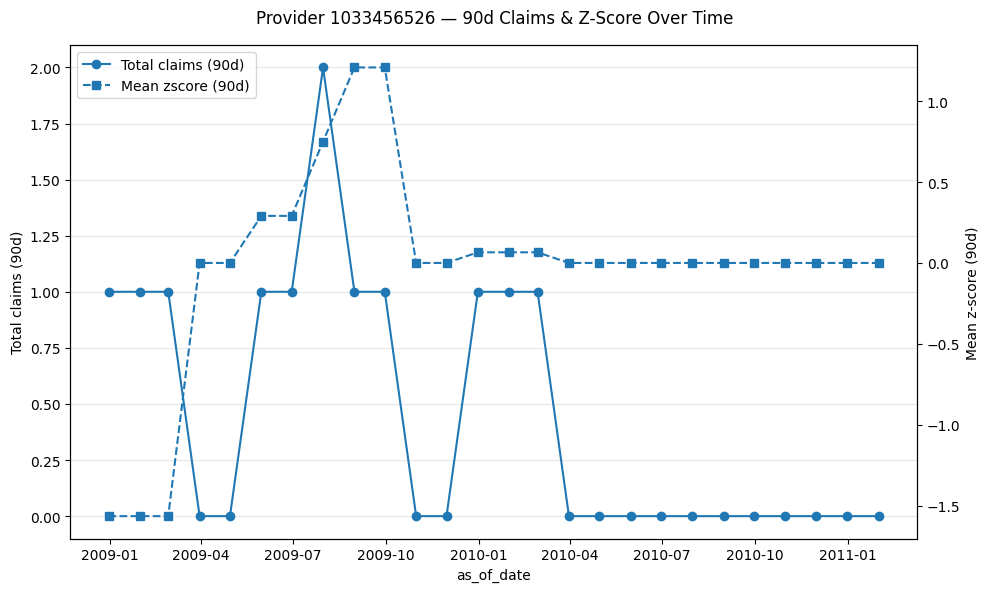

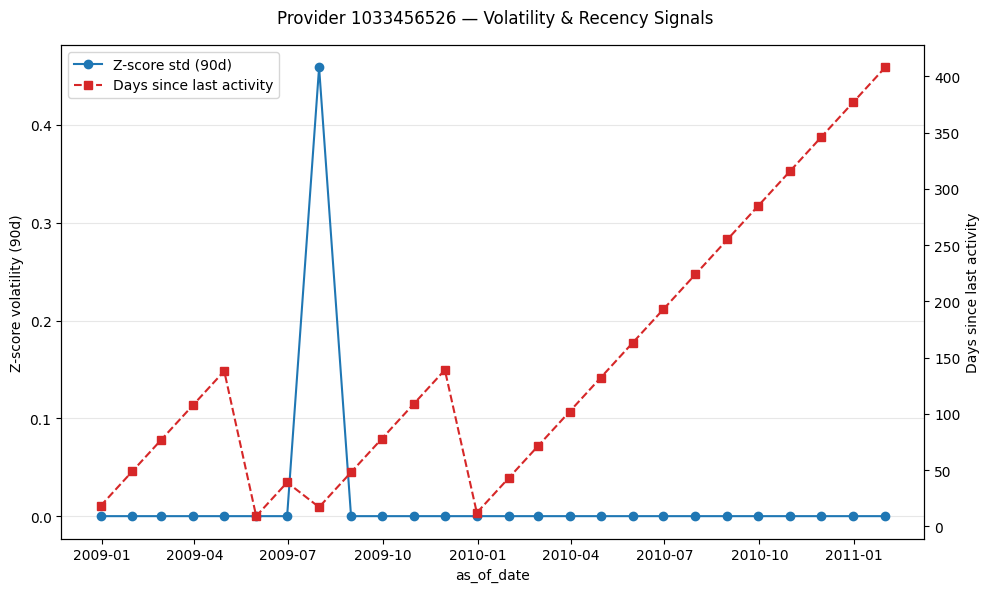


=== Provider 0888901330 ===


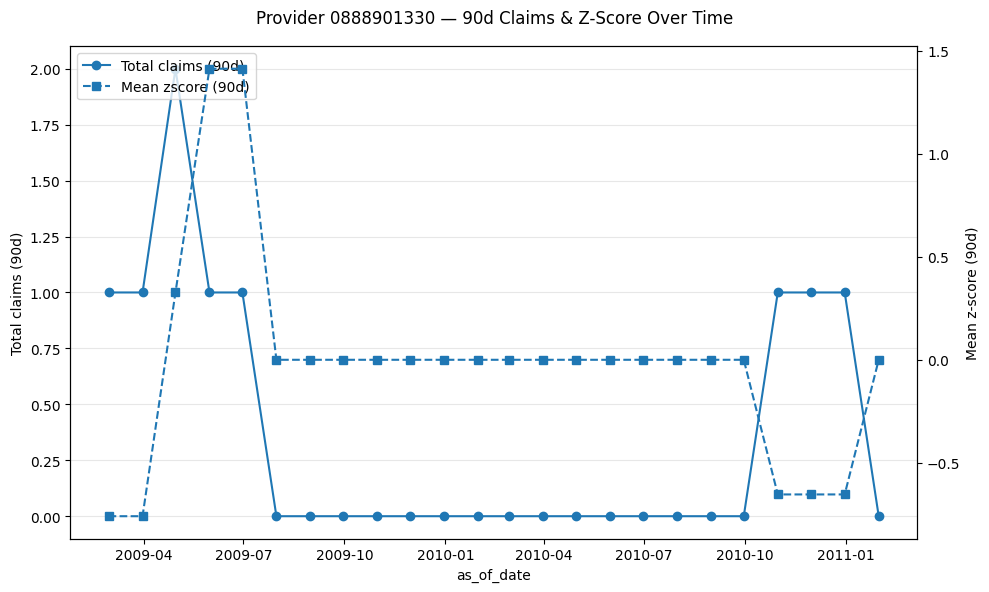

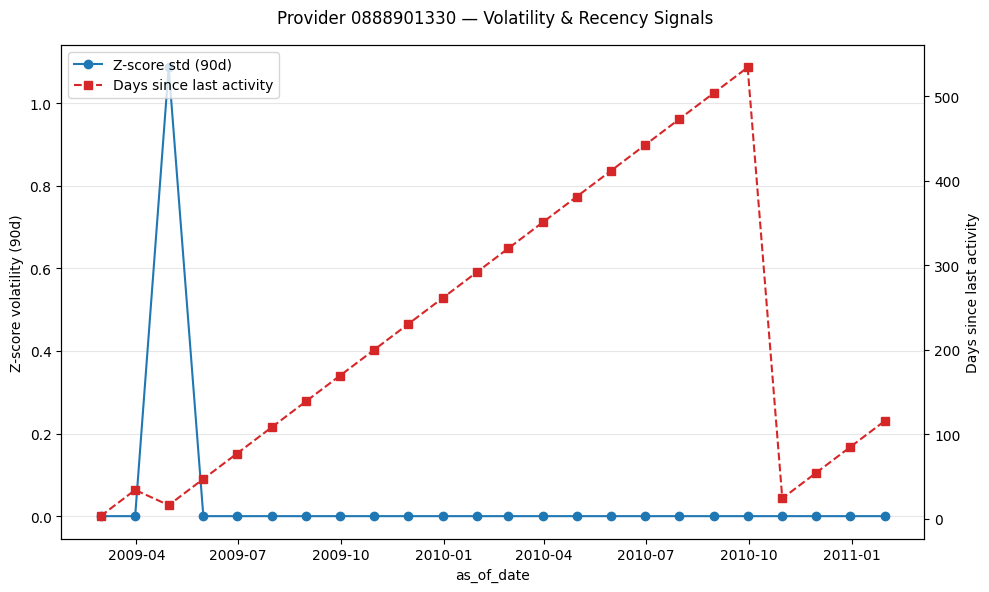


=== Provider 5111491524 ===


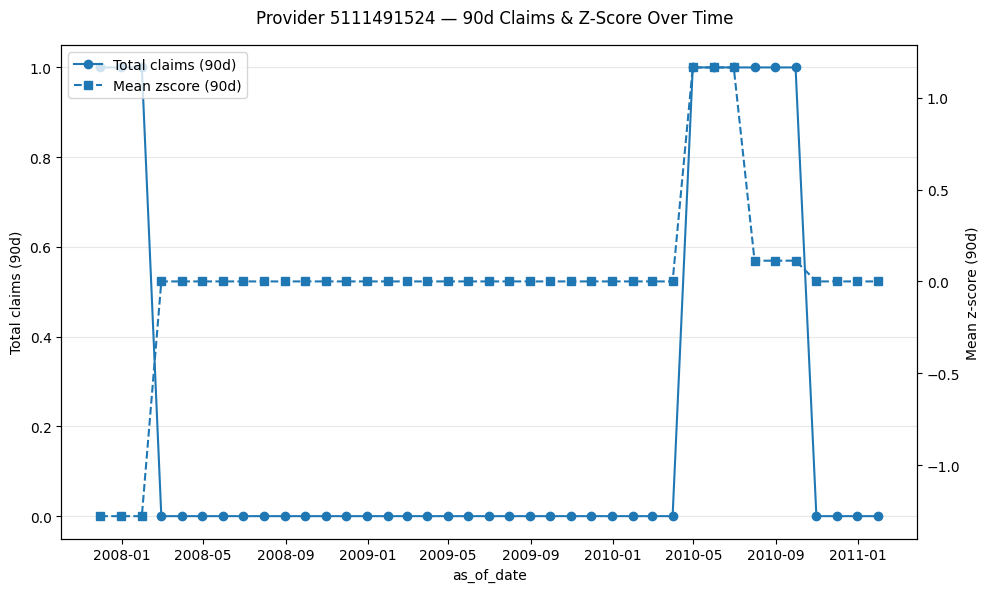

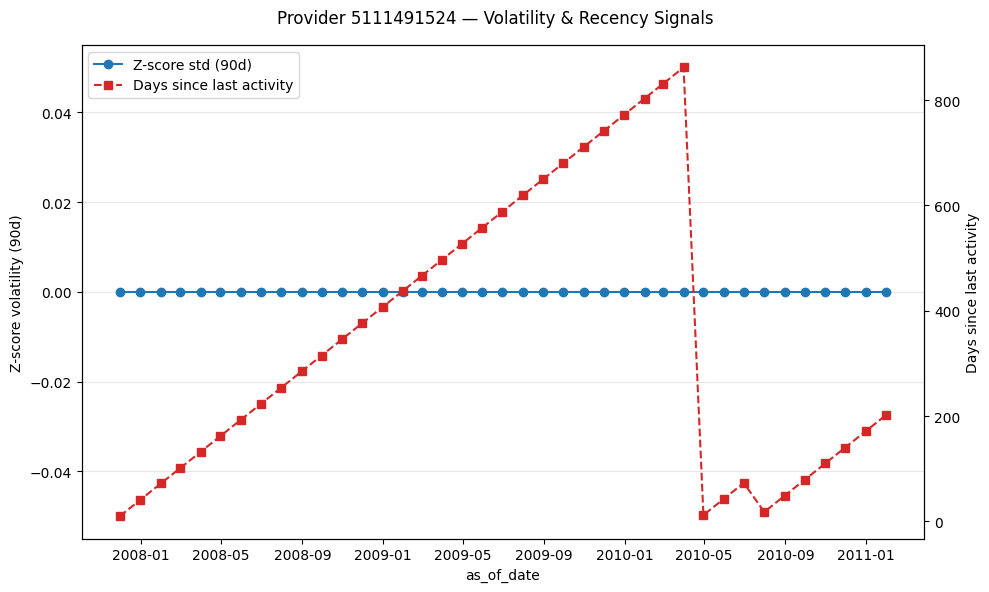


=== Provider 0329757128 ===


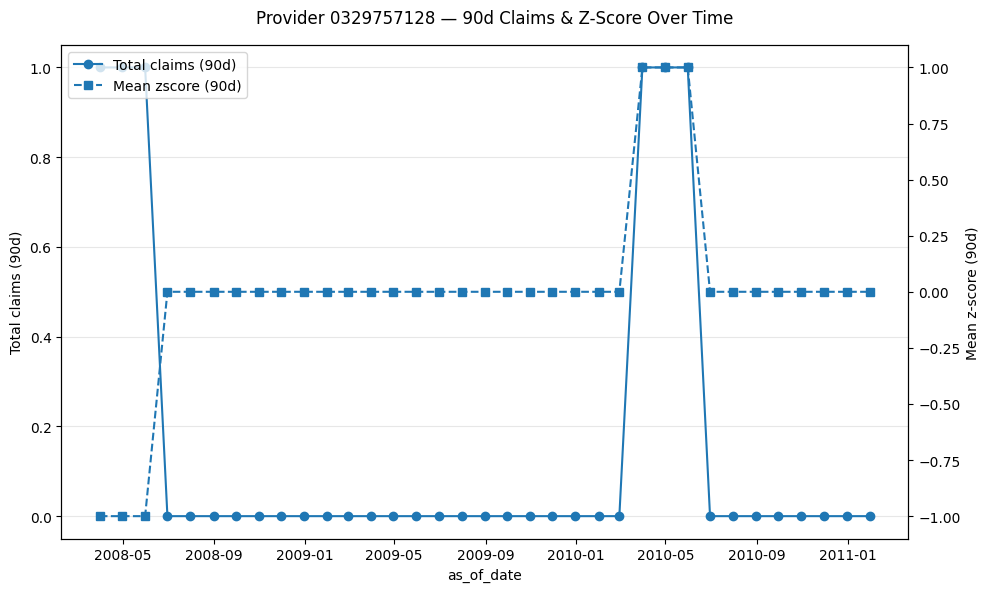

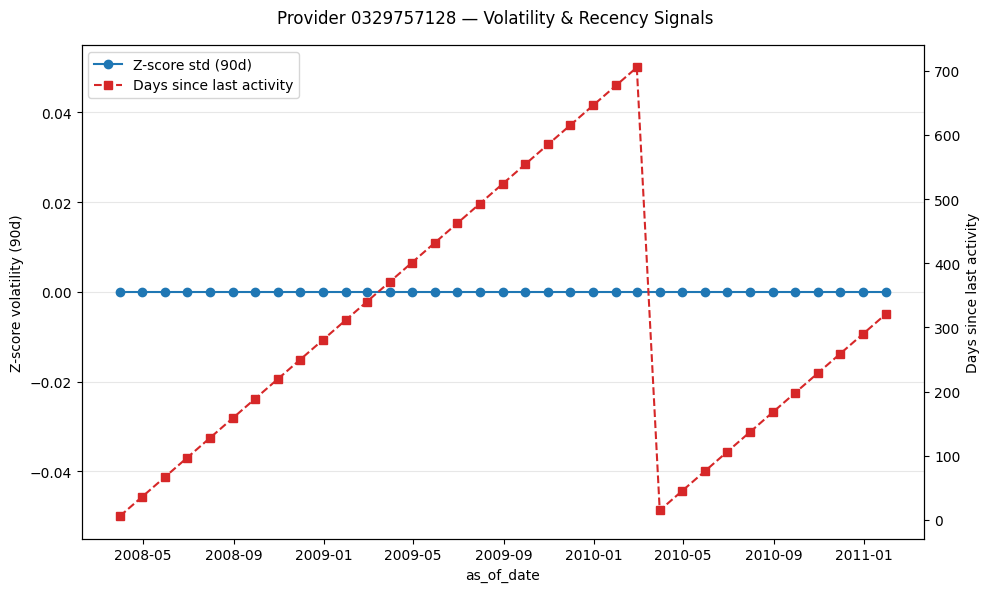


=== Provider 3265059745 ===


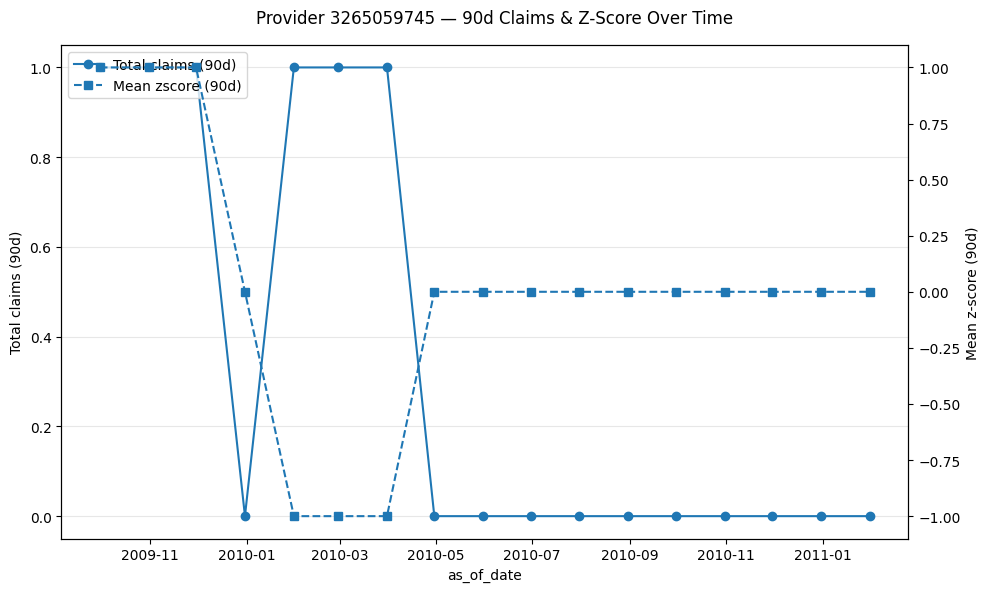

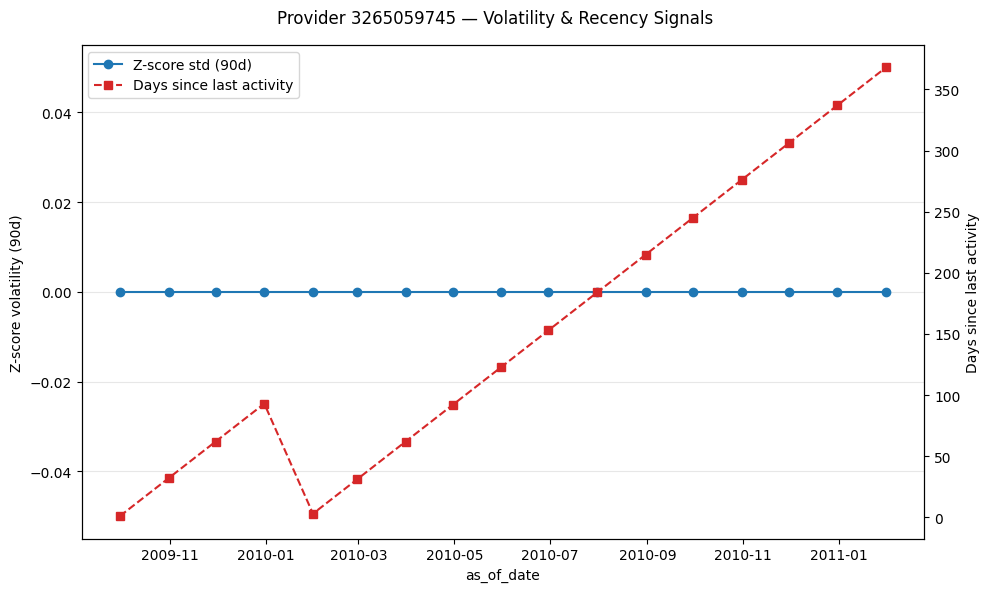

In [12]:
for pid in top_providers:
    print(f"\n=== Provider {pid} ===")
    plot_provider_timeseries(panel_all, pid)
    plot_provider_volatility_and_recency(panel_all, pid)